In [1]:
import pandas as pd
import numpy as np
import os
import sys
import polars as pl
import json
from joblib import Parallel, delayed
import deepchem
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Configure Polars 
cfg = pl.Config()
cfg.set_tbl_rows(20)
cfg.set_tbl_cols(50)
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, GroupShuffleSplit, ShuffleSplit, StratifiedKFold
import gc
import random
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import lap
from typing import List, Tuple, Union
import lap
from matplotlib import pyplot as plt
from rdkit.Chem import MACCSkeys

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/opt/conda/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [2]:
with open('/home/dangnh36/datasets/competitions/leash_belka/processed/meta/building_blocks.json', 'r') as f:
    bbs_meta = json.load(f)
    
for k, v in bbs_meta.items():
    print(k, '-->', len(v)) 

train_bbs --> 1145
train_bb1s --> 271
train_bb2s --> 693
train_bb3s --> 872
test_bb1s --> 341
test_bb2s --> 1140
test_bb3s --> 1389
test_bbs --> 2110
all_bbs --> 2110


In [3]:
train_scaffolds = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_scaffold.csv').collect()
train_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_v2.csv')\
    .select(
        pl.col('molecule'),
        pl.col('bb1', 'bb2', 'bb3').cast(pl.UInt16),
        pl.col('BRD4', 'HSA', 'sEH').cast(pl.UInt8),
        scaffold_idx = train_scaffolds['scaffold_idx'],
    )\
    .collect()
print(train_df.shape, train_df.estimated_size('mb'))
train_df

(98415610, 8) 8601.91998577118


molecule,bb1,bb2,bb3,BRD4,HSA,sEH,scaffold_idx
str,u16,u16,u16,u8,u8,u8,i64
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,4283326
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,4486646
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,1015728
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,196,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,253,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,1219,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,604,0,0,0,543172


In [4]:
test_scaffolds = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/test_scaffold.csv').collect()
mol_groups = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/test_v4.csv').select(pl.col('mol_group').cast(pl.UInt8)).collect()
test_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/test_v2.csv')\
    .select(
        pl.col('id','molecule'),
        pl.col('bb1', 'bb2', 'bb3').cast(pl.UInt16),
        pl.col('protein'),
        scaffold_idx = test_scaffolds['scaffold_idx']
    ).group_by('molecule').first().sort('id').with_columns(mol_group = mol_groups['mol_group']).collect()
print(test_df.shape, test_df.estimated_size('mb'))
test_df

(878022, 8) 85.05668830871582


molecule,id,bb1,bb2,bb3,protein,scaffold_idx,mol_group
str,i64,u16,u16,u16,str,i64,u8
"""C#CCCC[C@H](Nc…",295246830,1989,409,409,"""BRD4""",2217250,2
"""C#CCCC[C@H](Nc…",295246833,1989,409,1012,"""BRD4""",602641,2
"""C#CCCC[C@H](Nc…",295246836,1989,409,1722,"""BRD4""",4502748,2
"""C#CCCC[C@H](Nc…",295246839,1989,409,1078,"""BRD4""",3936208,2
"""C#CCCC[C@H](Nc…",295246842,1989,409,605,"""BRD4""",4550856,2
"""C#CCCC[C@H](Nc…",295246845,1989,409,521,"""BRD4""",4414349,2
"""C#CCCC[C@H](Nc…",295246848,1989,409,41,"""BRD4""",5367715,2
"""C#CCCC[C@H](Nc…",295246851,1989,409,1826,"""BRD4""",1422452,2
"""C#CCCC[C@H](Nc…",295246854,1989,409,1970,"""BRD4""",4752663,2


In [5]:
test_df.group_by('mol_group').count().sort('mol_group')

mol_group,count
u8,u32
0,369039
1,486390
2,11271
3,11322


In [6]:
nonshare_public_df = test_df.filter(pl.col('mol_group') == 2)
nonshare_public_df

molecule,id,bb1,bb2,bb3,protein,scaffold_idx,mol_group
str,i64,u16,u16,u16,str,i64,u8
"""C#CCCC[C@H](Nc…",295246830,1989,409,409,"""BRD4""",2217250,2
"""C#CCCC[C@H](Nc…",295246833,1989,409,1012,"""BRD4""",602641,2
"""C#CCCC[C@H](Nc…",295246836,1989,409,1722,"""BRD4""",4502748,2
"""C#CCCC[C@H](Nc…",295246839,1989,409,1078,"""BRD4""",3936208,2
"""C#CCCC[C@H](Nc…",295246842,1989,409,605,"""BRD4""",4550856,2
"""C#CCCC[C@H](Nc…",295246845,1989,409,521,"""BRD4""",4414349,2
"""C#CCCC[C@H](Nc…",295246848,1989,409,41,"""BRD4""",5367715,2
"""C#CCCC[C@H](Nc…",295246851,1989,409,1826,"""BRD4""",1422452,2
"""C#CCCC[C@H](Nc…",295246854,1989,409,1970,"""BRD4""",4752663,2


In [7]:
all_bbs = bbs_meta['all_bbs']
len(all_bbs)

2110

In [8]:
EPSILON = 1e-5

def linear_assignment_lapjv(
        cost_matrix: np.ndarray,
        max_cost: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Linear assignment using LapJV implementation.

    Linear assignment with specified max cost. All posible pair with higher cost
    will be treated equally (i.e having same cost in matching stage)
    and will not be treated as matched (gated).
    See https://github.com/nwojke/deep_sort/issues/84 or
    https://github.com/nwojke/deep_sort/issues/135 for more implementation details.

    Args:
        cost_matrix:
            Cost matrix of size M*N
        max_cost:
            Maximum cost allowed. A pair (cell) with higher cost will be gated.
    
    Returns:
        Tuple contain 3 list (matched, unmatched_a, unmatched_b).
        Each element in matched is in form of [a_idx, b_idx]
        unmatched_a contains row indices which are not matched.
        unmatched_b contains column indices which are not matched.
    """
    if cost_matrix.size == 0:
        return np.empty((0, 2),
                        dtype=int), tuple(range(cost_matrix.shape[0])), tuple(
                            range(cost_matrix.shape[1]))
    # treated every over range costs equally to remove bias
    # https://github.com/nwojke/deep_sort/issues/84
    # https://github.com/nwojke/deep_sort/issues/135
    cost_matrix[cost_matrix > max_cost] = max_cost + EPSILON
    matches, unmatched_a, unmatched_b = [], [], []
    _cost, a, b = lap.lapjv(cost_matrix, extend_cost=True, cost_limit=max_cost)
    for ia, vb in enumerate(a):
        if vb >= 0:
            matches.append([ia, vb])
    unmatched_a = np.where(a < 0)[0]
    unmatched_b = np.where(b < 0)[0]
    matches = np.asarray(matches)
    return matches, unmatched_a, unmatched_b




def get_ecfp(smile, radius=3, bits=2048):
    if smile is None:
        return None
    mol = Chem.MolFromSmiles(smile)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=bits)
    return fp


def get_maccs(smile):
    if smile is None:
        return None
    mol = Chem.MolFromSmiles(smile)
    fp = MACCSkeys.GenMACCSKeys(mol)
    return fp


In [9]:
train_bb1s = bbs_meta['train_bb1s']
train_bb2s = bbs_meta['train_bb2s']
train_bb3s = bbs_meta['train_bb3s']
train_bb23s = sorted(list(set(train_bb2s + train_bb3s)))
len(train_bb1s), len(train_bb23s)

(271, 874)

In [10]:
train_bb23s[:3]

['Br.Br.NCC1CCCN1c1cccnn1', 'Br.NCc1cccc(Br)n1', 'C#CCOc1ccc(CN)cc1.Cl']

In [11]:
nonshare_public_bb1_idxs = sorted(nonshare_public_df.select(pl.col('bb1').unique())['bb1'].to_list())
nonshare_public_bb2_idxs = sorted(nonshare_public_df.select(pl.col('bb2').unique())['bb2'].to_list())
nonshare_public_bb3_idxs = sorted(nonshare_public_df.select(pl.col('bb3').unique())['bb3'].to_list())
nonshare_public_bb23_idxs = sorted(list(set(nonshare_public_bb2_idxs + nonshare_public_bb3_idxs)))
len(nonshare_public_bb1_idxs), len(nonshare_public_bb2_idxs), len(nonshare_public_bb3_idxs), len(nonshare_public_bb23_idxs)

(17, 34, 36, 36)

In [12]:
nonshare_public_bb1s = [all_bbs[i] for i in nonshare_public_bb1_idxs]
nonshare_public_bb23s = [all_bbs[i] for i in nonshare_public_bb23_idxs]
nonshare_public_bb23s[:3]

['Cc1cccc(NC(=O)COc2ccc(CCN)cc2)c1.Cl',
 'Cl.Cl.N=C(N)c1cccc(CN)c1',
 'Cl.NCCc1ccc(S(N)(=O)=O)s1']

# BB Fingerprint + Tanimoto similarity

In [13]:
nonshare_public_bb1_ecfps = [get_ecfp(m) for m in nonshare_public_bb1s]
nonshare_public_bb23_ecfps = [get_ecfp(m) for m in nonshare_public_bb23s]
len(nonshare_public_bb1_ecfps), len(nonshare_public_bb23_ecfps)

(17, 36)

In [14]:
train_bb1_ecfps = [get_ecfp(m) for m in train_bb1s]
train_bb23_ecfps = [get_ecfp(m) for m in train_bb23s]
len(train_bb1_ecfps), len(train_bb23_ecfps)

(271, 874)

In [15]:
def get_sim_mat(smiles_list1, smiles_list2, fp = 'ecfp6', sim = 'tanimoto'):
    if fp == 'ecfp6':
        fps1 = [get_ecfp(m, 3, 2048) for m in smiles_list1]
        fps2 = [get_ecfp(m, 3, 2048) for m in smiles_list2]
    elif fp == 'ecfp4':
        fps1 = [get_ecfp(m, 2, 1024) for m in smiles_list1]
        fps2 = [get_ecfp(m, 2, 1024) for m in smiles_list2]
    elif fp == 'maccs':
        fps1 = [get_maccs(m) for m in smiles_list1]
        fps2 = [get_maccs(m) for m in smiles_list2]
    else:
        raise ValueError
    
    if sim == 'tanimoto':
        sim_func = DataStructs.BulkTanimotoSimilarity
    elif sim == 'cosine':
        sim_func = DataStructs.BulkCosineSimilarity
    elif sim == 'dice':
        sim_func = DataStructs.BulkDiceSimilarity
    elif sim == 'tversky':
        sim_func = DataStructs.BulkTverskySimilarity
    elif sim == 'rand':
        def _rand(x, y):
            return np.random.rand(1, len(y))
        sim_func = _rand
    else:
        raise ValueError
        
    sim_mat = np.full((len(fps1), len(fps2)), -1, dtype = np.float32)
    for i in range(len(fps2)):
        tmp = sim_func(fps2[i], fps1)
        sim_mat[:, i] = tmp
    return sim_mat

(271, 17)
MAX:
 [0.70238096 0.7361111  0.7457627  0.5625     0.739726   0.7205882
 0.65753424 0.6321839  0.6805556  0.7777778  0.6486486  0.6351351
 0.7758621  0.6621622  0.9322034  0.65       0.73134327]
MIN:
 [0.27272728 0.31632653 0.3090909  0.25619835 0.32258064 0.32608697
 0.31       0.26717559 0.31578946 0.32967034 0.32608697 0.31578946
 0.32692307 0.2857143  0.3063063  0.30252102 0.30701753]
DIFF:
 [0.42965367 0.41978458 0.4366718  0.30630165 0.41714537 0.39450124
 0.34753424 0.36500832 0.36476612 0.44810745 0.32256165 0.31934565
 0.44893903 0.3764479  0.6258971  0.34747896 0.42432573]
0 -> 17(218) with cost=0.7023809552192688
1 -> 161(294) with cost=0.7361111044883728
2 -> 183(2084) with cost=0.7457627058029175
3 -> 231(2055) with cost=0.5625
4 -> 5(1114) with cost=0.7397260069847107
5 -> 109(186) with cost=0.720588207244873
6 -> 110(589) with cost=0.6575342416763306
7 -> 144(2034) with cost=0.6321839094161987
8 -> 66(1669) with cost=0.6805555820465088
9 -> 40(1120) with cost=0

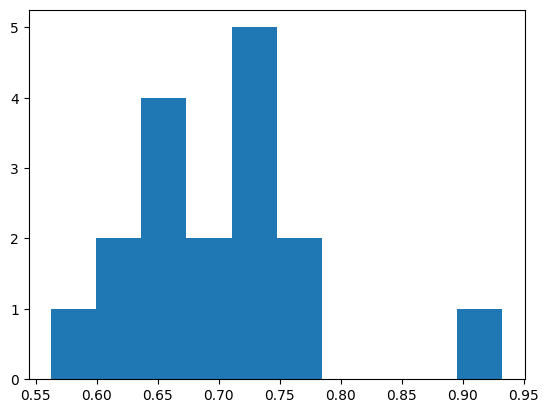

Val BB1 idxs: [218, 294, 2084, 2055, 1114, 186, 589, 2034, 1669, 1120, 1253, 504, 137, 347, 1147, 599, 2013]



-----------------------------



(874, 36)
MAX:
 [0.2535211  0.4117647  0.3809524  0.4        0.42857143 0.5555556
 0.29032257 0.4857143  0.47916666 0.29032257 0.36734694 0.31578946
 0.29090908 0.3529412  0.4827586  0.3888889  0.34375    0.20833333
 0.30645162 0.3043478  0.3043478  0.3018868  0.39534885 0.29090908
 0.33333334 0.45454547 0.2580645  0.4375     0.30232558 0.25925925
 0.34615386 0.37209302 0.4        0.32352942 0.27272728 0.32608697]
MIN:
 [0.02739726 0.025      0.03703704 0.03571429 0.01587302 0.01886792
 0.01724138 0.01587302 0.01369863 0.01666667 0.01351351 0.03773585
 0.02222222 0.01351351 0.01666667 0.01538462 0.04545455 0.01492537
 0.01538462 0.01388889 0.02       0.02222222 0.01515152 0.02222222
 0.03225806 0.01515152 0.03333334 0.01428571 0.02702703 0.03125
 0.01369863 0.01449275 0.03636364 0.02857143 0.03030303 0.01515152]
DIFF:
 [0.22612385 0.3867647  0

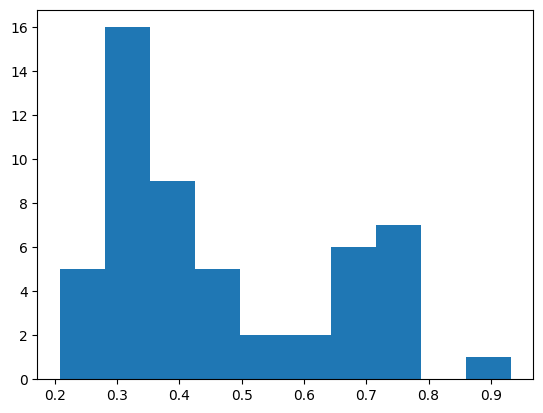

Val BB23 idxs: [2041, 684, 1749, 1425, 654, 1959, 84, 1161, 1268, 1982, 1603, 1906, 2066, 1407, 391, 2089, 1813, 821, 406, 1543, 1792, 960, 1351, 148, 1681, 130, 1587, 1564, 1331, 1815, 1337, 804, 528, 726, 474, 1366]
(11093, 8)


BRD4,HSA,sEH
f64,f64,f64
1.198954,0.378617,0.351573


In [17]:
FP = 'ecfp6'
SIM = 'tanimoto'
DUP = 1
INV = False

bb1_sim_mat = get_sim_mat(train_bb1s, nonshare_public_bb1s * DUP, fp = FP, sim = SIM)
print(bb1_sim_mat.shape)
print('MAX:\n', bb1_sim_mat.max(axis = 0))
print('MIN:\n', bb1_sim_mat.min(axis = 0))
print('DIFF:\n', bb1_sim_mat.max(axis = 0) - bb1_sim_mat.min(axis = 0))

matches, unmatched_a, unmatched_b = linear_assignment_lapjv(1.0 - bb1_sim_mat if not INV else bb1_sim_mat, max_cost=1.0)
matches = sorted(matches, key = lambda x: x[1])
assert len(unmatched_b) == 0
val_bb1_idxs = []
costs = []
for idx_a, idx_b in matches:
    val_bb1_idxs.append(all_bbs.index(train_bb1s[idx_a]))
    cost = bb1_sim_mat[idx_a, idx_b]
    costs.append(cost)
    print(f'{idx_b} -> {idx_a}({all_bbs.index(train_bb1s[idx_a])}) with cost={cost}')
plt.hist(costs)
plt.show()

print('Val BB1 idxs:', val_bb1_idxs)

print('\n\n\n-----------------------------\n\n\n')

bb23_sim_mat = get_sim_mat(train_bb23s, nonshare_public_bb23s * DUP, fp = FP, sim = SIM)
print(bb23_sim_mat.shape)
print('MAX:\n', bb23_sim_mat.max(axis = 0))
print('MIN:\n', bb23_sim_mat.min(axis = 0))
print('DIFF:\n', bb23_sim_mat.max(axis = 0) - bb23_sim_mat.min(axis = 0))

matches, unmatched_a, unmatched_b = linear_assignment_lapjv(1.0 - bb23_sim_mat if not INV else bb23_sim_mat, max_cost=1.0)
matches = sorted(matches, key = lambda x: x[1])
assert len(unmatched_b) == 0
val_bb23_idxs = []
cost = []
for idx_a, idx_b in matches:
    val_bb23_idxs.append(all_bbs.index(train_bb23s[idx_a]))
    cost = bb23_sim_mat[idx_a, idx_b]
    costs.append(cost)
    print(f'{idx_b} -> {idx_a} with cost={cost}')
plt.hist(costs)
plt.show()

print('Val BB23 idxs:', val_bb23_idxs)

nonshare_bb_split_meta = {
    'val_bb1s': val_bb1_idxs,
    'val_bb23s': val_bb23_idxs
}
SAVE_PATH = f'/home/dangnh36/datasets/competitions/leash_belka/processed/cv/nonshare_bb_split/bb_{FP}_{SIM}_dup={DUP}{"_inv" if INV else ""}.json'
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
with open(SAVE_PATH, 'w') as f:
    json.dump(nonshare_bb_split_meta, f, indent=4)
    
nonshare_val_df = train_df.filter((pl.col('bb1').is_in(val_bb1_idxs)) & (pl.col('bb2').is_in(val_bb23_idxs)) & (pl.col('bb3').is_in(val_bb23_idxs)))
print(nonshare_val_df.shape)
nonshare_val_df.select(pl.mean('BRD4', 'HSA', 'sEH') * 100)

In [18]:
s1 = [14, 104, 346, 364, 509, 558, 582, 589, 742, 866, 928, 1088, 1126, 1314, 1779, 1893, 1945]
s2 = [218, 294, 2084, 2055, 1114, 186, 589, 2034, 1669, 1120, 1253, 504, 137, 347, 1147, 599, 2013]

list(set(s1).intersection(set(s2)))

[589]

In [19]:
s1 = [43, 119, 266, 399, 518, 578, 638, 809, 829, 882, 954, 1001, 1033, 1091, 1128, 1158, 1161, 1275, 1298, 1299, 1304, 1308, 1366, 1372, 1391, 1414, 1481, 1482, 1488, 1644, 1699, 1707, 1711, 2018, 2025, 2101]
s2 = [2041, 684, 1749, 1425, 654, 1959, 84, 1161, 1268, 1982, 1603, 1906, 2066, 1407, 391, 2089, 1813, 821, 406, 1543, 1792, 960, 1351, 148, 1681, 130, 1587, 1564, 1331, 1815, 1337, 804, 528, 726, 474, 1366]
list(set(s1).intersection(set(s2)))

[1161, 1366]

## NOTES

- 589 has 1.59% HSA
- 1161 has 9.8847% BRD4
- 1366

- ECFP6 + Tanimoto: 1.198954	0.378617	0.351573
- ECFP4 + Tanimoto: 1.112607	0.34096	0.13459
- MACCS + Tanimoto: 1.85941	0.090703	0.353741

- ECFP6 + Cosine: 1.117621	0.44164	0.35151
- ECFP4 + Cosine: 1.112607	0.34096	0.13459
- MACCS + Cosine: 1.8322	0.090703	0.199546

- ECFP6 + Dice: 1.198954	0.378617	0.351573
- ECFP4 + Dice: 1.112607	0.34096	0.13459
- MACCS + Dice: 1.85941	0.090703	0.353741

# Split by molecule scaffold similarity